In [1]:
# Import libraries we will use for this lab
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt

**1. In this section we will define functions to extract the wanted data from ISA**

In [2]:
# 
url1 = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter"
url2 = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html"
r = requests.get(url1,params={'ww_i_reportmodel':133685247})
soup = bs(r.content, "lxml")

# 
Xsl=soup.find_all("input",{'name':'ww_i_reportModelXsl'})
XslValue = int(Xsl[0].get("value"))

# Parameters
sections = {}
years = {}
semesters = {}
#summerwinter = {}

# Returns list of all possible key-value for the parameter
def getParameterOptions(parameterName):
    result = {}
    select = soup.find_all("select",{'name':parameterName})[0]
    options = select.find_all("option")
    for o in options:
        key = o.text
        value = o.get("value")
        if(value!='null'):
            result[key]=int(value)
    return result

sections = getParameterOptions('ww_x_UNITE_ACAD')
years = getParameterOptions('ww_x_PERIODE_ACAD')
semesters = getParameterOptions('ww_x_PERIODE_PEDAGO')
#summer_winter = getParameterOptions('ww_x_HIVERETE')

#def getParameterValues(section, year, semester, summerwinter):
def getParameterValues(section, year, semester):
    params={'ww_i_reportmodel':133685247,'ww_i_reportModelXsl':XslValue,'ww_b_list':1}
    params['ww_x_UNITE_ACAD'] = sections[section]
    params['ww_x_PERIODE_ACAD'] = years[year]
    params['ww_x_PERIODE_PEDAGO'] = semesters[semester]
    #params['ww_x_HIVERETE'] = summer_winter[summerwinter]
    return params

# We noticed that we can retrieve a page using only the GPS parameter.
#def getGPS(section, year, semester, summerwinter):
def getGPS(section, year, semester):
    #payload = getParameterValues(section, year, semester, summerwinter)
    payload = getParameterValues(section, year, semester)
    r = requests.get(url1, params = payload)
    soup = bs(r.content, "lxml")
    script = soup.find_all("a")[1].get("onclick")
    code = script.replace('loadReport(\'ww_x_GPS=', '')
    code = code.replace('\');return false;','')
    return int(code)

# Returns the HTML page for the inputs parameters
#def getPage(section, year, semester, summerwinter):
def getPage(section, year, semester):
    #gps = getGPS(section, year, semester, summerwinter)
    gps = getGPS(section, year, semester)
    payload = {'ww_x_GPS':gps, 'ww_i_reportmodel':133685247, 'ww_i_reportModelXsl':XslValue}
    r = requests.get(url2, params = payload)
    return r

**2. In this section we will use the previous function to build a table with columns [SCIPER, GENDER, SEMESTER] that contains all semesters spent by students in Bachelor. Hence, a repeated row (n times) means that the student did the corresponding semester n times.**

In [3]:
# A function that returns a list of students in a degree(Bachelor or Master) in a range of year
def getListOfStudents(section,degree,startingYear,endingYear):
    
    # Create the resulting table
    if degree=='B':
        table= pd.DataFrame(columns=['SCIPER','GENDER','SEMESTER'])
    else:
        table= pd.DataFrame(columns=['SCIPER','GENDER','SPECIALIZATION','MINOR','SEMESTER','YEAR'])
    
    # First for loop to iterate over all possible years
    for i in range(startingYear,endingYear+1):
        # Year is the string corresponding to the current year
        year=str(i)+"-"+str(i+1)
        # Calculate number of semesters
        if degree =='B':
            numberOfSemesters = 6;
        else:
            numberOfSemesters = 3;
    
        # Second for loop to iterate over all possible semesters
        for j in range(1,numberOfSemesters+1):
            # Semester is the string corresponding to the current semester
            if degree=='B':
                semester="Bachelor semestre "+str(j)
            else:
                semester="Master semestre "+str(j)
            # Load the page corresponding to the informatique section and the current year and semester
            request = getPage(section, year, semester)
            # Create a BeautifulSoup object for the loaded html page
            soup = bs(request.content,'html.parser')
            # Use the find all method to extract the list of all students. In this part we used the body of the html answer 
            # of the ISA server (using Postman) to adjust the index of this list so that each element of the list corresponds
            # to a student and not other data.
            list_of_students=soup.findAll('tr')[2:]
        
            # Third loop to go throw the list and extract the student's information
            for student in list_of_students:
                # Get the list of all the attributes of a current student (again, the positions of the attributes found with Postman)
                current_student_infos=student.findAll('td')
                # Extract the gender attribute
                current_student_gender=current_student_infos[0].string
                # Extract the sciper attribute
                current_student_sciper=current_student_infos[10].string
                if degree=='M':
                    # Extract the minor attribute
                    current_student_minor=current_student_infos[6].text
                    # Extract the specialization attribute
                    current_student_specialization=current_student_infos[4].text
                # Build a new row (dataFrame) with the extracted information
                if degree=='B':
                    current_student_new_table_entry = pd.DataFrame([[current_student_sciper,current_student_gender,str(j)]],columns=['SCIPER','GENDER','SEMESTER'])
                else:
                    current_student_new_table_entry = pd.DataFrame([[current_student_sciper,current_student_gender,current_student_specialization,current_student_minor,str(j),str(i)]],columns=['SCIPER','GENDER','SPECIALIZATION','MINOR','SEMESTER','YEAR'])
                # Append the new row to the resulting table
                table=table.append(current_student_new_table_entry)

    # Once the table is populated change 'Monsieur' with 'M' and 'Madame' with 'F' in thegender column
    table=table.replace({'GENDER': {'Monsieur': 'M','Madame':'F'}})
    #index the resulting table
    table.index=range(0,len(table))
    return table

In [4]:
# Specify the section, level and years for exercise 1
section="Informatique"
degree='B'
startingYear=2007
endingYear=2016
sciper_gender_table = getListOfStudents(section,degree,startingYear,endingYear)
sciper_gender_table.head()

,SCIPER,GENDER,SEMESTER
0,169569,M,1
1,174905,M,1
2,173922,M,1
3,179406,M,1
4,179428,M,1


**3. In this part we will compute the set of students that did their semester 1 and 6 between 2007 and 2007 
and other sets that we will not use later but just to have an idea of the bachelor cycle of different students of IN**

In [5]:
#Compute the set of all scipers
all_students_distinct= set(sciper_gender_table.SCIPER)

#Compute the set of all scipers corresponding to students that did their semester 1 between 2007 and 2017
students_with_semester_1_entry=set(sciper_gender_table.loc[sciper_gender_table['SEMESTER']=='1','SCIPER'])

#Compute the set of all scipers corresponding to students that did their semester 6 between 2007 and 2017
students_with_semester_6_entry=set(sciper_gender_table.loc[sciper_gender_table['SEMESTER']=='6','SCIPER'])

#Compute the set of all scipers corresponding to students that did their semester 1 and 6 between 2007 and 2017
#THIS IS THE SET WE ARE INTERESTED IN FOR THE TEST
students_with_semester_1_and_6_entry=students_with_semester_1_entry.intersection(students_with_semester_6_entry)

#Compute the set of all scipers corresponding to students did their semester 6 between 2007 and 2017 but did semester 1 before 2007
#by substracting students_with_semester_1_and_6_entry from student_with_semester_6
#we nedd to copy students_with_semester_6_entry because the method difference_update that substract doesn't make a copy
#and change directly the calling set
student_with_semester_6_and_not_1=students_with_semester_6_entry.copy()
student_with_semester_6_and_not_1.difference_update(students_with_semester_1_and_6_entry)


print("The total number of students is: "+ str(len(all_students_distinct)))
print("The total number of students that did their semester 1 between 2007 and 2017 is: "+str(len(students_with_semester_1_entry)))
print("The total number of students that did their semester 6 between 2007 and 2017 is: "+str(len(students_with_semester_6_entry)))
print("The total number of students that did their semester 1 and 6 between 2007 and 2017 is: "+ str (len(students_with_semester_1_and_6_entry)))
print("The total number of students that did their semester 6 between 2007 and 2017 but did semester 1 before 2007 is: "+ str (len(student_with_semester_6_and_not_1)))

The total number of students is: 1477
The total number of students that did their semester 1 between 2007 and 2017 is: 1323
The total number of students that did their semester 6 between 2007 and 2017 is: 516
The total number of students that did their semester 1 and 6 between 2007 and 2017 is: 397
The total number of students that did their semester 6 between 2007 and 2017 but did semester 1 before 2007 is: 119


**Coclusion:** The number of students that reached their sixth semester between spring 2007 and spring 2017 are 516 students. But only 379 of them began their firts semester of bachelor in or after autaumn 2007. Students who reached the sixth semester between 2007 and 2017 but their beginning year is unkown from the data are not taken into account because the duration of their bachelor is unkown.**
**------------------------------------------------------------------------------------------------------------------**

**4. In this part we will compute the table showing the total number of month spent in the bachelor relative to the students we found in the previous section (students that did their semester 1 and 6 between 2007 and 2017)**

One way to do that is to merge a dataFrame containing one column 'SCIPER' containing all scipers of students that did their semester 1 and 6 between 2007 and 2017 and the original table 'sciper_gender_table' with an **inner join** which will result in all rows in 'sciper_gender_table' that have a scipr numbers we are interested in.

In [6]:
#List of students that did their semester 1 and 6 between 2007 and 2017 as a dataFrame
students_with_semester_1_and_6_entry_DFrame=pd.DataFrame(list(students_with_semester_1_and_6_entry),columns=['SCIPER'])
students_with_semester_1_and_6_entry_DFrame.head()

,SCIPER
0,205617
1,202946
2,223344
3,225730
4,228496


In [7]:
# merge the previous dataFrame with the original table
sciper_gender_table_semester_1_and_6=pd.merge(sciper_gender_table,students_with_semester_1_and_6_entry_DFrame,how='inner')
sciper_gender_table_semester_1_and_6.head(10)

,SCIPER,GENDER,SEMESTER
0,169569,M,1
1,169569,M,2
2,169569,M,3
3,169569,M,4
4,169569,M,5
5,169569,M,6
6,174905,M,1
7,174905,M,2
8,174905,M,3
9,174905,M,4


**Conclusion:** The resulting table consist of multiple raws for each SCIPER. The number of raws with the same SCIPER represents the number of semesters spent by the student with this SCIPER in Bachelor. 
Hence, we are assuming that a semester during which **a student is not registred in any course doesn't count in the total number of semesters a student spend in Bachelor.** This assumption avoid us to count extra semesters where students are not registred so are not taking any course. Hence, we only count semesters in which the student is effectively regestred and taking at least ine course.

**5. In this section we will group the resulting table by student to compute the number of semesters spent in the bachelor for each students and then transform the number of semesters to the number of months**

In [8]:
# Group by SCIPER and GENDER to get the table of all different students
# The count method will count the number of raws corresponding to each SCIPER in the SMESTER column
# Which corresponds as we said earlier to the number of semester spent by the student doing his bachelor
total_number_of_semesters_of_bachelor=sciper_gender_table_semester_1_and_6.groupby(by=['SCIPER','GENDER']).count()

# Change the name of SEMESTER column to 'Number of semesters of bachelor'
total_number_of_semesters_of_bachelor.columns=['NUMBER OF SEMESTERS OF BACHELOR']

total_number_of_semesters_of_bachelor.head()

,,NUMBER OF SEMESTERS OF BACHELOR
SCIPER,GENDER,
147008,M,6
169569,M,6
169731,M,8
169795,M,9
171195,M,6


In [9]:
# Create the table that shows the number of months of bachelor per student as a copy from the table of semesters
total_number_of_months_of_bachelor=total_number_of_semesters_of_bachelor.copy()

# Add a new column that represents the number of months and fill it by multiplyng the correspondent number of
#semesters by 6 (1 semester= 6 months)
total_number_of_months_of_bachelor['NUMBER OF MONTHS OF BACHELOR']= 6* total_number_of_months_of_bachelor['NUMBER OF SEMESTERS OF BACHELOR']

# Remove the column corresponding to the number of semesters and sort according to the number of months
total_number_of_months_of_bachelor=total_number_of_months_of_bachelor[['NUMBER OF MONTHS OF BACHELOR']].sort_values('NUMBER OF MONTHS OF BACHELOR')

total_number_of_months_of_bachelor.head()


,,NUMBER OF MONTHS OF BACHELOR
SCIPER,GENDER,
204222,M,24
147008,M,36
217629,M,36
217612,M,36
217530,M,36


**Problem**: We can see from the table that the first entry corresponds to a student that finished his bachelor in 24 months while the minimum is 36. The data corresponding to this student is missing for semester 3 and 4 are missing as shown above:

In [10]:
# Show all rows with sciper='204222'
sciper_gender_table[sciper_gender_table['SCIPER']=='204222']

,SCIPER,GENDER,SEMESTER
1830,204222,M,1
1955,204222,M,2
4389,204222,M,5
4508,204222,M,6


Hence, removing this row will make our data more robust:

In [11]:
total_number_of_months_of_bachelor=total_number_of_months_of_bachelor[1:]
total_number_of_months_of_bachelor.head()

,,NUMBER OF MONTHS OF BACHELOR
SCIPER,GENDER,
147008,M,36
217629,M,36
217612,M,36
217530,M,36
217469,M,36


Now we can group our table according to the gender we can compute for example the mean number of months spent in the bachelor for each gender:

In [12]:
# Reindex the table of total number of months because the gender column was an index and then group by GENDER
# and compute the mean for each gender and take the 'Number of months of bachelor' column
mean_number_of_months_of_bachelor_by_gender=total_number_of_months_of_bachelor.reset_index().groupby(by=['GENDER']).mean()[['NUMBER OF MONTHS OF BACHELOR']]
## Rename the column of the mean number of months spent in the Bachelor
mean_number_of_months_of_bachelor_by_gender.columns=['MEAN NUMBER OF MONTHS SPENT IN BACHELOR']
mean_number_of_months_of_bachelor_by_gender

,MEAN NUMBER OF MONTHS SPENT IN BACHELOR
GENDER,
F,40.758621
M,42.686649


**6. In this section we will apply a test to the data to know whether the difference of the period spent to finish the Bachelor between man and women is statistically significant:**

We decided to use a two-tailed Welch's t-test for the following reasons:
    - A Welch's t-test’s statistical significance indicates whether or not the difference between two groups’ averages most likely reflects a “real” difference in the population from which the groups were sampled. Hence satisfies the aim of the question.
    - Our two samples don't have the same size and is Welch's t-test is more reliable when the two samples have unequal variances and unequal sample sizes than the Student's t-test.
    - We need to use two tailed test because we are interested in knowing whether the difference of averege number of months spent in Bachelor for each gender is statistically significant in both directions: males spend more months in the bachelor than females or the opposite.

In [48]:
# From the total number of months in Bachelor table, we compute the male and female samples
male_sample=total_number_of_months_of_bachelor.reset_index().set_index(['GENDER']).loc['M'][['NUMBER OF MONTHS OF BACHELOR']]
female_sample=total_number_of_months_of_bachelor.reset_index().set_index(['GENDER']).loc['F'][['NUMBER OF MONTHS OF BACHELOR']]

female_sample.head()

,NUMBER OF MONTHS OF BACHELOR
GENDER,
F,36
F,36
F,36
F,36
F,36


In [14]:
# We run the Welch's t-test 
stats.ttest_ind(male_sample,female_sample,equal_var=False)

Ttest_indResult(statistic=array([ 1.22426904]), pvalue=array([ 0.22927095]))

**Conclusion:** The null hypothesis is that the averege number of months spent in the Bachelor for male and female is the same. The found pvalue=0.22 is larger than 0.05. Hence, we cannot reject the null hypothesis. In other words, the difference in average is not statistically significant. 

# Part 2: MASTER

In [15]:
# Specify the section, level and years for exercise 2
section = "Informatique"
degree = 'M'
startingYear = 2007
endingYear = 2016
sciper_gender_table = getListOfStudents(section,degree,startingYear,endingYear)
sciper_gender_table.head()

,SCIPER,GENDER,SPECIALIZATION,MINOR,SEMESTER,YEAR
0,153066,M,,,1,2007
1,180027,F,,,1,2007
2,152232,M,,,1,2007
3,177395,M,,,1,2007
4,161970,M,,,1,2007


In [16]:
#Compute the set of all scipers
all_students_distinct = set(sciper_gender_table.SCIPER)

students_with_speciality = set(sciper_gender_table.loc[sciper_gender_table['SPECIALIZATION']!='','SCIPER'])
students_with_minor = set(sciper_gender_table.loc[sciper_gender_table['MINOR']!='','SCIPER'])
students_with_minor_or_speciality = students_with_minor.union(students_with_speciality)
students_without_minor_nor_speciality = all_students_distinct.copy()
students_without_minor_nor_speciality.difference_update(students_with_minor_or_speciality)

#Compute the set of all scipers corresponding to students that did their semester 1 between 2007 and 2017
students_with_semester_1_entry = set(sciper_gender_table.loc[sciper_gender_table['SEMESTER']=='1','SCIPER'])

#Compute the set of all scipers corresponding to students that did their semester 2 between 2007 and 2017
students_with_semester_2_entry = set(sciper_gender_table.loc[sciper_gender_table['SEMESTER']=='2','SCIPER'])

#Compute the set of all scipers corresponding to students that did their semester 2 between 2007 and 2017
students_with_semester_3_entry = set(sciper_gender_table.loc[sciper_gender_table['SEMESTER']=='3','SCIPER'])

final_list_without_minor_nor_speciality = students_with_semester_1_entry.intersection(students_with_semester_2_entry).intersection(students_without_minor_nor_speciality)
final_list_with_minor_or_speciality = students_with_semester_1_entry.intersection(students_with_semester_3_entry).intersection(students_with_minor_or_speciality)

#Compute the set of all scipers corresponding to students that did their semester 1 and 6 between 2007 and 2017
#THIS IS THE SET WE ARE INTERESTED IN FOR THE TEST
final_list_students = final_list_without_minor_nor_speciality.union(final_list_with_minor_or_speciality)

In [17]:
#List of students that did their semester 1 and 6 between 2007 and 2017 as a dataFrame
final_list_students_DFrame = pd.DataFrame(list(final_list_students),columns=['SCIPER'])
final_list_students_DFrame.head()

,SCIPER
0,185005
1,160254
2,205617
3,202946
4,183534


In [18]:
# merge the previous dataFrame with the original table
# For specialization, we took the last entry. For example, if we have an entry for specialization in Semester 2
# and a null entry in Semester 3, we consider that the student dropped the specialization
sciper_gender_table_semester_final = pd.merge(sciper_gender_table,final_list_students_DFrame,how='inner')
for sciper in final_list_students:
    entries = sciper_gender_table_semester_final.loc[sciper_gender_table_semester_final['SCIPER']==sciper]
    n = len(entries)
    spe = entries.iloc[n-1].loc['SPECIALIZATION']
    minor = entries.iloc[n-1].loc['MINOR']
    sciper_gender_table_semester_final.loc[sciper_gender_table_semester_final['SCIPER']==sciper,'SPECIALIZATION']=spe
    sciper_gender_table_semester_final.loc[sciper_gender_table_semester_final['SCIPER']==sciper,'MINOR']=minor

In [19]:
# Group by SCIPER and GENDER to get the table of all different students
# The count method will count the number of raws corresponding to each SCIPER in the SMESTER column
# Which corresponds as we said earlier to the number of semester spent by the student doing his bachelor
grouped = sciper_gender_table_semester_final.groupby(by=['SCIPER','GENDER','SPECIALIZATION','MINOR'])
f = {'SEMESTER':'count', 'YEAR':'max'}
total_number_of_semesters_of_master = grouped.agg(f)
#total_number_of_semesters_of_master_with_count.columns['NUMBER OF SEMESTERS OF MASTER']
#total_number_of_semesters_of_master_with_year=grouped
total_number_of_semesters_of_master.columns = ['NUMBER OF SEMESTERS OF MASTER','FINISHING YEAR']
#total_number_of_semesters_of_master_with_year
#total_number_of_semesters_of_master=pd.merge(total_number_of_semesters_of_master_with_count,total_number_of_semesters_of_master_with_year,how='inner')

total_number_of_semesters_of_master.head()

,,,,NUMBER OF SEMESTERS OF MASTER,FINISHING YEAR
SCIPER,GENDER,SPECIALIZATION,MINOR,,
146330,M,,,3,2008
146742,M,"Signals, Images and Interfaces",,5,2012
146929,M,,,2,2007
147008,M,,,4,2012
152232,M,,"Mineur en Management, technologie et entrepreneuriat",3,2008


In [20]:
# Create the table that shows the number of months of bachelor per student as a copy from the table of semesters
total_number_of_months_of_master = total_number_of_semesters_of_master.copy()

# Add a new column that represents the number of months and fill it by multiplyng the correspondent number of
#semesters by 6 (1 semester= 6 months)
total_number_of_months_of_master['NUMBER OF MONTHS OF MASTER'] = 6* total_number_of_months_of_master['NUMBER OF SEMESTERS OF MASTER']

# Remove the column corresponding to the number of semesters and sort according to the number of months
total_number_of_months_of_master = total_number_of_months_of_master[['NUMBER OF MONTHS OF MASTER','FINISHING YEAR']].sort_values('NUMBER OF MONTHS OF MASTER')

total_number_of_months_of_master.head()


,,,,NUMBER OF MONTHS OF MASTER,FINISHING YEAR
SCIPER,GENDER,SPECIALIZATION,MINOR,,
211251,M,,,12,2011
191447,M,,,12,2011
175503,M,,,12,2009
233210,M,,,12,2013
191313,M,,,12,2009


In [65]:
average_stay = total_number_of_months_of_master['NUMBER OF MONTHS OF MASTER'].mean()
average_stay = round(average_stay,3)
print("the average stay at EPFL for master students: "+ str(average_stay))

the average stay at EPFL for master students: 19.468


In [68]:
# Reindex the table of total number of months because the gender column was an index and then group by GENDER
# and compute the mean for each gender and take the 'Number of months of bachelor' column
mean_number_of_months_of_master_by_speciality = total_number_of_months_of_master.reset_index().groupby(by=['SPECIALIZATION','MINOR']).mean().round(3)[['NUMBER OF MONTHS OF MASTER']]
## Rename the column of the mean number of months spent in the Bachelor
mean_number_of_months_of_master_by_speciality.columns = ['MEAN NUMBER OF MONTHS SPENT IN MASTER']
mean_number_of_months_of_master_by_speciality

MEAN NUMBER OF MONTHS SPENT IN MASTER
SPECIALIZATION                 MINOR                                                                                    
                                                                                                                  17.533
                               Area and Cultural Studies minor                                                    20.000
                               Information security minor                                                         21.500
                               Mineur en Biocomputing                                                             22.286
                               Mineur en Etudes asiatiques contemporaines                                         30.000
                               Mineur en Ingénierie financière                                                    22.286
                               Mineur en Management, technologie et entreprene...                                 23.062
                               Mineur en Mathématiques                                                            27.000
                               Mineur en Microtechnique                                                           18.000
                               Mineur en Neuroprosthétiques                                                       18.000
                               Mineur en Neurosciences computationnelles                                          24.000
                               Mineur en Technologies spatiales                                                   27.000
Biocomputing                                                                                                      26.000
Computer Engineering - SP                                                                                         21.667
Computer Science Theory                                                                                           18.000
Data Analytics                                                                                                    18.000
Foundations of Software                                                                                           23.379
Information Security - SP                                                                                         19.000
Internet Information Systems                                                                                      18.000
Internet computing                                                                                                22.390
Service science                                                                                                   20.000
Signals, Images and Interfaces                                                                                    25.500
Software Systems                                                                                                  20.000

In [106]:
# Extract all the students with a specialization
students_with_spe = total_number_of_months_of_master.reset_index()
students_with_spe = students_with_spe.loc[students_with_spe['SPECIALIZATION'] != '']
students_with_spe.head()

,SCIPER,GENDER,SPECIALIZATION,MINOR,NUMBER OF MONTHS OF MASTER,FINISHING YEAR
152,217389,M,Internet computing,,18,2015
156,217530,M,"Signals, Images and Interfaces",,18,2015
164,261006,F,Data Analytics,,18,2016
170,215623,M,Information Security - SP,,18,2016
181,211478,M,Computer Engineering - SP,,18,2012


In [107]:
# Average stay per each category of specialization
mean_nb_of_months_per_spe = students_with_spe.groupby(by='SPECIALIZATION').mean().round(3)[['NUMBER OF MONTHS OF MASTER']]
mean_nb_of_months_per_spe.columns = ['MEAN NUMBER OF MONTHS SPENT IN MASTER']
mean_nb_of_months_per_spe

,MEAN NUMBER OF MONTHS SPENT IN MASTER
SPECIALIZATION,
Biocomputing,26.000
Computer Engineering - SP,21.667
Computer Science Theory,18.000
Data Analytics,18.000
Foundations of Software,23.379
Information Security - SP,19.000
Internet Information Systems,18.000
Internet computing,22.390
Service science,20.000


In [108]:
mean_nb_of_months_per_spe.describe()

,MEAN NUMBER OF MONTHS SPENT IN MASTER
count,11.000000
mean,21.085091
std,2.936103
min,18.000000
25%,18.500000
50%,20.000000
75%,22.884500
max,26.000000


In [ ]:
# Two-tailed Welch's t-test at a 95% confidence level
stats.ttest_ind(male_sample_master, female_sample_master, equal_var = False)

# Part 3: BONUS

In [23]:
# Reindex the table of total number of months because the gender column was an index and then group by GENDER
# and compute the mean for each gender.
mean_number_of_months_of_master_by_gender = total_number_of_months_of_master.reset_index().groupby(by=['GENDER']).mean()[['NUMBER OF MONTHS OF MASTER']]

mean_number_of_months_of_master_by_gender.columns = ['MEAN NUMBER OF MONTHS SPENT IN MASTER']
mean_number_of_months_of_master_by_gender

,MEAN NUMBER OF MONTHS SPENT IN MASTER
GENDER,
F,19.636364
M,19.442219


We are going to conduct a two-tailed Welch's t-test at a 95% confidence level and see if it correctly rejects the null hypothesis is that the mean of both groups (FEMALE/MALE) are the same. 
We decided to use this type of statistical test for the same reason as for Part 1.

In [58]:
# From the total number of months in Master table, we compute the male and female samples
male_sample_master = total_number_of_months_of_master.reset_index().set_index(['GENDER']).loc['M'][['NUMBER OF MONTHS OF MASTER']]
female_sample_master = total_number_of_months_of_master.reset_index().set_index(['GENDER']).loc['F'][['NUMBER OF MONTHS OF MASTER']]

print("Nb Female samples: "+ str(len(female_sample_master)))
print("Variance Female samples: "+ str(female_sample_master['NUMBER OF MONTHS OF MASTER'].var()))

print("Nb Male samples: "+ str(len(male_sample_master)))
print("Variance Male samples: "+ str(male_sample_master['NUMBER OF MONTHS OF MASTER'].var()))

Nb Female samples: 99
Variance Female samples: 35.86641929499074
Nb Male samples: 649
Variance Male samples: 32.139017291559696


As the two groups samples have unequal variances and unequal sample sizes, using Welch's t-test is a good choice. 

In [60]:
# Two-tailed Welch's t-test at a 95% confidence level
stats.ttest_ind(male_sample_master, female_sample_master, equal_var = False)

Ttest_indResult(statistic=array([-0.30253701]), pvalue=array([ 0.76274054]))

**Conclusion:** If we were using a 95% confidence level we would fail to reject the null hypothesis, since the p-value is greater than the corresponding significance level of 5%. 

In [25]:
# Reindex the table of total number of months because the gender column was an index and then group by GENDER and 
# FINISHING YEAR and compute the mean number of months spent in Master for each finishing year and for each gender.
mean_number_of_months_of_master_by_gender = total_number_of_months_of_master.reset_index().groupby(by=['GENDER','FINISHING YEAR']).mean()[['NUMBER OF MONTHS OF MASTER']]
mean_number_of_months_of_master_by_gender.columns = ['MEAN NUMBER OF MONTHS SPENT IN MASTER']
mean_number_of_months_of_master_by_gender

MEAN NUMBER OF MONTHS SPENT IN MASTER
GENDER FINISHING YEAR                                       
F      2007                                        12.000000
       2008                                        15.000000
       2009                                        22.800000
       2010                                        16.000000
       2011                                        17.142857
       2012                                        20.333333
       2013                                        24.000000
       2014                                        19.125000
       2015                                        23.333333
       2016                                        20.470588
M      2007                                        12.000000
       2008                                        16.372881
       2009                                        19.272727
       2010                                        17.689655
       2011                                        18.468750
       2012                                        21.166667
       2013                                        20.605263
       2014                                        20.750000
       2015                                        20.344828
       2016                                        20.052632

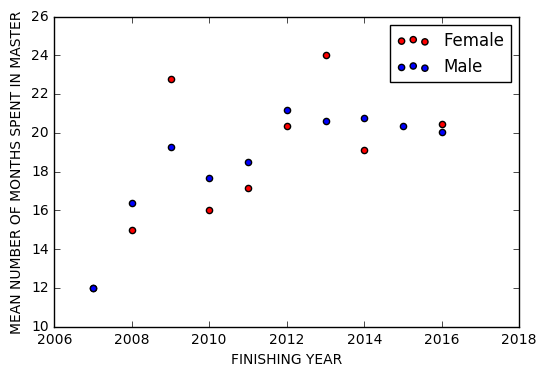

In [26]:
mean_number_of_months_of_master = mean_number_of_months_of_master_by_gender.reset_index()
mean_number_of_months_of_master = mean_number_of_months_of_master[['FINISHING YEAR', 'MEAN NUMBER OF MONTHS SPENT IN MASTER']]

# We change the type of the column FINISHING YEAR to int (possible to plot).
mean_number_of_months_of_master['FINISHING YEAR'] = mean_number_of_months_of_master['FINISHING YEAR'].astype(int)

nbYear = 10
mean_number_of_months_of_master_Female = mean_number_of_months_of_master.head(nbYear)
mean_number_of_months_of_master_Male = mean_number_of_months_of_master.tail(nbYear)

# Scatter plot: 
ax = mean_number_of_months_of_master_Female.plot(kind='scatter', x='FINISHING YEAR', y='MEAN NUMBER OF MONTHS SPENT IN MASTER', color='Red', label='Female');
mean_number_of_months_of_master_Male.plot(kind='scatter', x = 'FINISHING YEAR', y = 'MEAN NUMBER OF MONTHS SPENT IN MASTER', color='Blue', label='Male', ax=ax);
plt.show()